# 사전작업

## 라이브러리 로드

In [111]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings("ignore")
gc.enable()

In [663]:
pd.set_option('max_rows', 5000)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

## 데이터 로드

In [3]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 8min 42s


## train, test 합치기

In [5]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194754

## Get Date - AvSigVersion

In [6]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

# 모델

## 시간 포함 모델

### train test split

In [119]:
debug = False

In [120]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

if debug:
    train = train[:1000000]
    test = test[:1000000]
    
gc.collect()

1913

In [97]:
train.MachineIdentifier = range(len(train))
train.reset_index(drop=True, inplace=True)
test.MachineIdentifier = range(len(test))
test.reset_index(drop=True, inplace=True)

In [98]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [99]:
train.shape, test.shape

((8921483, 85), (7853253, 85))

In [100]:
y_train = np.array(train['HasDetections'])
train_ids = train.index

In [101]:
del train['HasDetections'], train['MachineIdentifier'], test
gc.collect()

588

In [102]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)

In [103]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])

In [104]:
train.shape

(8921483, 8093)

In [106]:
save_npz('./data_temp/train.npz', train, compressed=True)
del ohe, train
gc.collect()

588

In [107]:
train = load_npz('./data_temp/train.npz')

In [108]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_train_time = np.zeros(train_ids.shape[0])
counter = 0

In [109]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.1,
                                   num_leaves=2**12-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    
    print("predicting")
    lgb_train_time[test_index] = lgb_model.predict_proba(X_val)[:,1]
    counter += 1
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.598963	valid_0's auc: 0.735681
[200]	valid_0's binary_logloss: 0.599806	valid_0's auc: 0.734788
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.598889	valid_0's auc: 0.735765
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.598669	valid_0's auc: 0.736121
[200]	valid_0's binary_logloss: 0.599393	valid_0's auc: 0.7353
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.598633	valid_0's auc: 0.736152
predicting
Fold 3

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.598681	valid_0's auc: 0.735861
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.59867	valid_0's auc: 0.735881
predicting


## 시간 미포함 모델

### train test split

In [26]:
debug = False

In [27]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

if debug:
    train = train[:100000]
    test = test[:100000]
    
gc.collect()

12

### 시간 관련 피처 드랍

In [9]:
DROP_FEATURES = ['EngineVersion', 'AppVersion', 'AvSigVersion', 
                 'OsBuild', 'OsPlatformSubRelease', 'OsBuildLab', 
                 'IeVerIdentifier',
                 'Census_OSVersion', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_FirmwareVersionIdentifier',
                 'Date', 'Date_YMD']

In [10]:
train = train.drop(DROP_FEATURES, axis = 1)
test = test.drop(DROP_FEATURES, axis = 1)

In [11]:
train.MachineIdentifier = range(len(train))
train.reset_index(drop=True, inplace=True)
test.MachineIdentifier = range(len(test))
test.reset_index(drop=True, inplace=True)

In [12]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [13]:
train.shape, test.shape

((8921483, 71), (7853253, 71))

In [14]:
y_train = np.array(train['HasDetections'])
train_ids = train.index

In [15]:
del train['HasDetections'], train['MachineIdentifier'], test
gc.collect()

504

In [16]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)

In [17]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])

In [18]:
train.shape

(8921483, 5728)

In [19]:
save_npz('./data_temp/train.npz', train, compressed=True)
del ohe, train
gc.collect()

490

In [20]:
train = load_npz('./data_temp/train.npz')

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_train_no_time = np.zeros(train_ids.shape[0])
counter = 0

In [22]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.1,
                                   num_leaves=2**12-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   max_bin=120,
                                   lambda_l1=6,
                                   lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    
    print("predicting")
    lgb_train_no_time[test_index] = lgb_model.predict_proba(X_val)[:,1]
    counter += 1
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.722204	valid_0's binary_logloss: 0.609151
[200]	valid_0's auc: 0.723244	valid_0's binary_logloss: 0.608347
[300]	valid_0's auc: 0.723317	valid_0's binary_logloss: 0.608308
Early stopping, best iteration is:
[275]	valid_0's auc: 0.723344	valid_0's binary_logloss: 0.608279
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.7221	valid_0's binary_logloss: 0.609301
[200]	valid_0's auc: 0.72313	valid_0's binary_logloss: 0.608509
[300]	valid_0's auc: 0.723287	valid_0's binary_logloss: 0.6084
[400]	valid_0's auc: 0.723281	valid_0's binary_logloss: 0.60843
Early stopping, best iteration is:
[336]	valid_0's auc: 0.723321	valid_0's binary_logloss: 0.608379
predicting
Fold 3

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.722451	valid_0's binary_logloss: 0.608843
[200]	valid_0's 

In [56]:
pd.DataFrame(lgb_train_no_time).to_csv('./data_temp/temp_no_time.csv')

In [23]:
t = pd.DataFrame(lgb_train_no_time)

In [28]:
t['Date_YMD'] = train.Date_YMD

In [29]:
t.columns = ['HasDetections', 'Date_YMD']

In [30]:
t = t.groupby('Date_YMD').HasDetections.agg(['mean', 'size'])

In [31]:
t = t.reset_index()

In [32]:
t = t[t.Date_YMD >= '2017-01-01']

In [55]:
lgb_train_time = pd.read_csv('./data_temp/temp.csv').drop(['Unnamed: 0'], axis=1)

In [42]:
# tt = pd.DataFrame(lgb_train_time)

In [43]:
tt['Date_YMD'] = train.Date_YMD

In [44]:
tt.columns = ['HasDetections', 'Date_YMD']

In [45]:
tt = tt.groupby('Date_YMD').HasDetections.agg(['mean', 'size'])

In [46]:
tt = tt.reset_index()

In [47]:
tt = tt[tt.Date_YMD >= '2017-01-01']

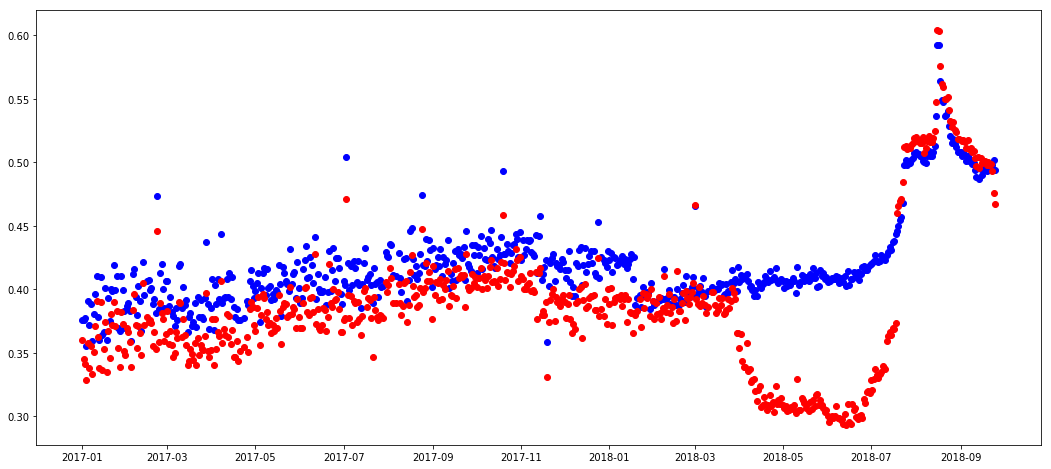

In [48]:
plt.figure(figsize=(18,8))
plt.plot(t.Date_YMD, t['mean'], 'bo')
plt.plot(tt.Date_YMD, tt['mean'], 'ro')

In [54]:
roc_auc_score(train.HasDetections, lgb_train_no_time)

0.7234379899583797

# 실험시작

In [548]:
Date_YMD = data[~data.HasDetections.isna()].Date_YMD

In [549]:
time = pd.read_csv('./data_temp/temp.csv').drop(['Unnamed: 0'], axis=1)
no_time = pd.read_csv('./data_temp/temp_no_time.csv').drop(['Unnamed: 0'], axis=1)

In [550]:
time['Date_YMD'] = Date_YMD
no_time['Date_YMD'] = Date_YMD

time.columns = ['HasDetections', 'Date_YMD']
no_time.columns = ['HasDetections', 'Date_YMD']

## condition

In [623]:
time_temp = time.groupby('Date_YMD').HasDetections.agg(['mean', 'size']).reset_index()
no_time_temp = no_time.groupby('Date_YMD').HasDetections.agg(['mean', 'size']).reset_index()

In [624]:
start = '2018-01-01'
end = '2018-11-25'
condition = ((time_temp.Date_YMD) >= start) & (time_temp.Date_YMD <= end)

In [625]:
time_temp = time_temp[condition]
no_time_temp = no_time_temp[condition]

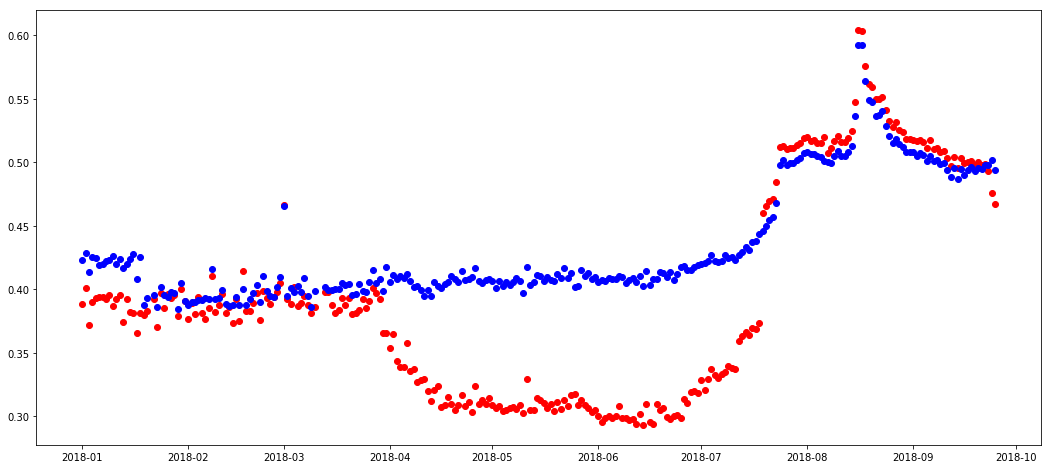

In [626]:
plt.figure(figsize=(18, 8))
plt.plot(time_temp.Date_YMD, time_temp['mean'], 'ro')
plt.plot(no_time_temp.Date_YMD, no_time_temp['mean'], 'bo')

In [627]:
def custom(data):
    return data[(data < 0.9) & (data > 0.1)].mean()

In [628]:
def custom_2(data):
    return data[(data >= 0.8) | (data <= 0.2)].sum()

In [629]:
custom_temp = no_time.groupby('Date_YMD').HasDetections.agg([custom]).reset_index()

In [630]:
custom_temp = custom_temp.rename(columns={'custom':'mean'})

In [631]:
custom_temp = custom_temp[condition]

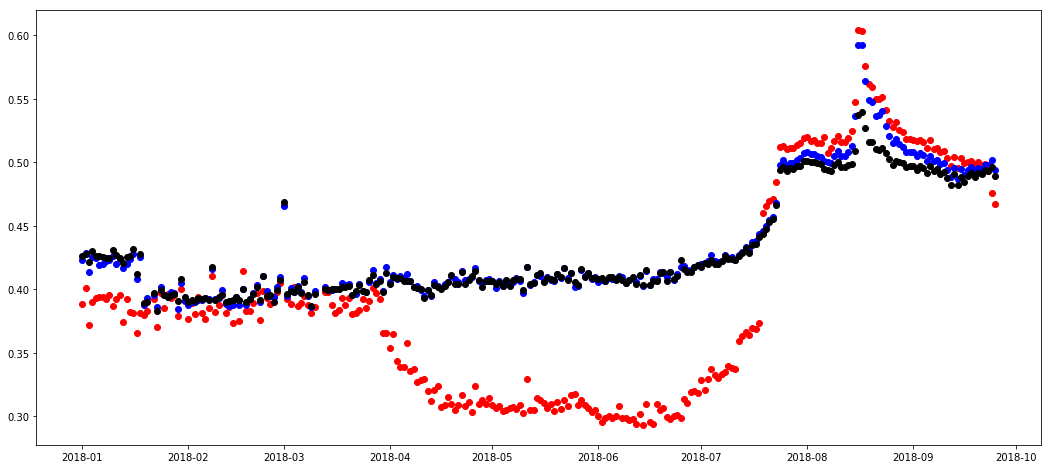

In [632]:
plt.figure(figsize=(18, 8))
plt.plot(time_temp.Date_YMD, time_temp['mean'], 'ro')
plt.plot(no_time_temp.Date_YMD, no_time_temp['mean'], 'bo')
plt.plot(custom_temp.Date_YMD, custom_temp['mean'], 'ko')

In [633]:
# 4월 01일 ~ 8월 01일

In [634]:
temp = custom_temp[(custom_temp.Date_YMD >= '2018-04-01') & (custom_temp.Date_YMD <= '2018-08-01')]

In [635]:
temp2 = time_temp[(time_temp.Date_YMD >= '2018-04-01') & (time_temp.Date_YMD <= '2018-08-01')]

In [636]:
temp['new_size'] =  temp2['mean'] / temp['mean']

In [637]:
temp = no_time.merge(temp[['Date_YMD', 'new_size']], how='left', on='Date_YMD').fillna(0)

In [638]:
temp['new_filter']= ((no_time.HasDetections < 0.7) & (no_time.HasDetections > 0.3)) * 1

In [639]:
temp.new_size = temp.new_size * temp.new_filter

In [640]:
temp.new_size = temp.new_size.replace(0,1)

In [641]:
no_time['mean'] = temp['HasDetections'] * temp['new_size']

In [642]:
no_time_temp = no_time.groupby('Date_YMD')['mean'].agg(['mean', 'size']).reset_index()

In [643]:
no_time_temp = no_time_temp[condition]

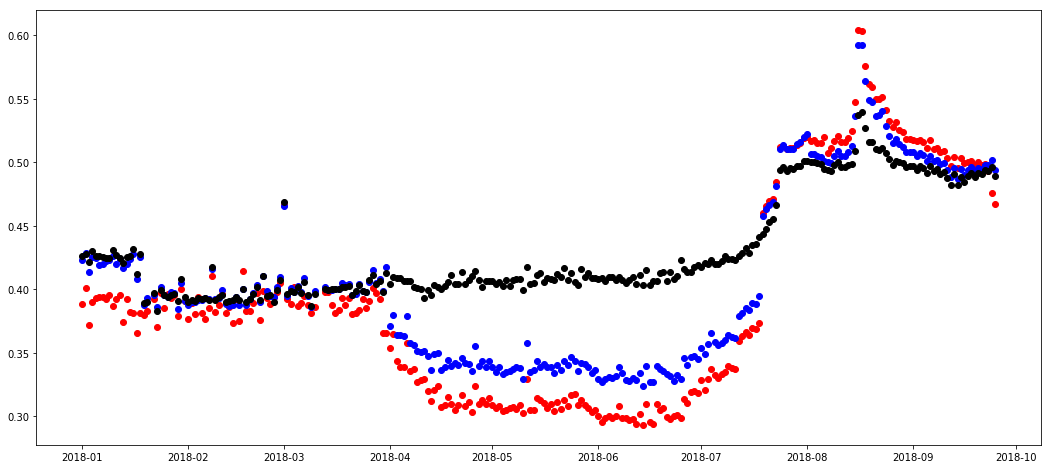

In [644]:
plt.figure(figsize=(18, 8))
plt.plot(time_temp.Date_YMD, time_temp['mean'], 'ro')
plt.plot(no_time_temp.Date_YMD, no_time_temp['mean'], 'bo')
plt.plot(custom_temp.Date_YMD, custom_temp['mean'], 'ko')

In [645]:
filt = (train.Date_YMD == '2018-06-01')

In [646]:
roc_auc_score(train.HasDetections[filt], no_time['mean'][filt])

0.6490501759986853

In [649]:
no_time['HasDetections'][filt].mean()

0.4056557687027957

In [ ]:
sns.distplot()

In [648]:
train.HasDetections[filt].mean()

0.2948032097821934

In [538]:
roc_auc_score(train.HasDetections, no_time['mean'])

0.715965549904788

In [610]:
roc_auc_score(train.HasDetections[filt], no_time['HasDetections'][filt])

0.6521345206930803

In [650]:
train.HasDetections[filt].mean()

0.2948032097821934

In [651]:
no_time['HasDetections'][filt].mean()

0.4056557687027957

In [652]:
roc_auc_score(train.HasDetections[filt], no_time['mean'][filt])

0.6490501759986853

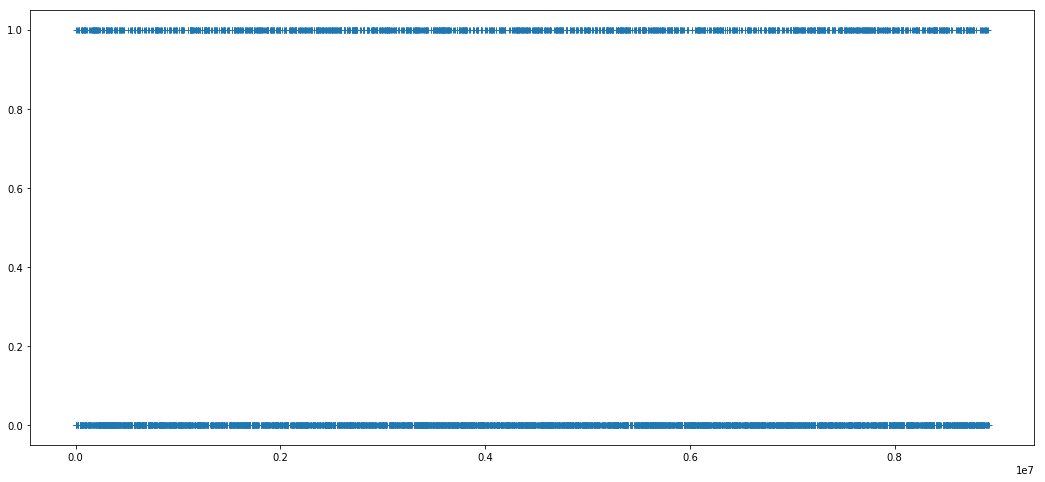

In [670]:
plt.figure(figsize=(18,8))
plt.plot(pd.DataFrame({"real": train.HasDetections[filt], "test": no_time['HasDetections'][filt]}).sort_values('test').real, '+')

In [666]:
pd.DataFrame({"real": train.HasDetections[filt], "test": no_time['HasDetections'][filt]}).sort_values('test')

,real,test
1543847,0.0,0.017278
2219384,0.0,0.022356
8080198,0.0,0.022631
5765950,0.0,0.027273
532979,0.0,0.030470
3889246,0.0,0.033280
3672287,0.0,0.034190
2875627,0.0,0.035449
6075680,0.0,0.037246
4577694,0.0,0.038319


In [314]:
no_time[no_time.Date_YMD == '2018-05-01']

,HasDetections,Date_YMD,mean
2105,0.147895,2018-05-01,0.112224
3007,0.236218,2018-05-01,0.179245
6188,0.195209,2018-05-01,0.148127
10711,0.632691,2018-05-01,0.480093
11413,0.294128,2018-05-01,0.223187
16172,0.480478,2018-05-01,0.364592
16317,0.473891,2018-05-01,0.359594
17801,0.333560,2018-05-01,0.253109
18438,0.100682,2018-05-01,0.076399
19151,0.109602,2018-05-01,0.083167


In [316]:
train[train.Date_YMD == '2018-05-01']

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Date,Date_YMD
2105,2105,win8defender,1.1.14800.3,4.14.17639.18041,1.267.611.0,0,0.0,1,NaN,579.0,3.0,1.0,1,93,64168.0,27.0,119.0,64,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2206.0,251667.0,2.0,5.0,1985.0,NaN,29824.0,SSD,29273.0,0,2048.0,Notebook,13.203125,1024.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.371,amd64,rs3_release,16299,371,Core,CORE,Reset,8.0,31,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33075.0,0,NaN,0.0,0,0,0.0,1.0,8.0,0.0,2018-05-01 06:43:00,2018-05-01
3007,3007,win8defender,1.1.14800.3,4.12.17007.18022,1.267.632.0,0,7.0,0,NaN,62773.0,1.0,1.0,1,201,66202.0,27.0,267.0,-5,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,0.0,0,NaN,0.0,111.0,NaN,1.0,1.0,Notebook,Windows.Desktop,384.0,28408.0,2.0,5.0,2042.0,NaN,305245.0,HDD,288615.0,0,2048.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.309,amd64,rs3_release,16299,309,CoreSingleLanguage,CORE_SINGLELANGUAGE,Reset,35.0,148,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,556.0,38156.0,1,NaN,0.0,0,0,0.0,0.0,11.0,0.0,2018-05-01 14:07:00,2018-05-01
6188,6188,win8defender,1.1.14800.3,4.14.17639.18041,1.267.615.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,149,6988.0,NaN,181.0,56,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2102.0,250461.0,4.0,5.0,2412.0,NaN,122104.0,SSD,121489.0,0,4096.0,MiniPC,23.000000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,IBSClean,24.0,109,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,NOT_SET,NaN,486.0,53252.0,0,NaN,0.0,0,0,0.0,NaN,NaN,0.0,2018-05-01 07:42:00,2018-05-01
10711,10711,win8defender,1.1.14800.3,4.11.15063.447,1.267.615.0,0,7.0,0,NaN,50397.0,2.0,1.0,1,66,22066.0,27.0,89.0,88,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,0.0,107.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189554.0,2.0,5.0,1931.0,NaN,476940.0,HDD,475957.0,0,4096.0,Notebook,15.500000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.15063.786,amd64,rs2_release,

# End

In [79]:
# time_idx = data.groupby(['Date_YMD']).size().index

# temp = pd.DataFrame(time_idx)

# condition = (temp.Date_YMD >= '2018-01-15')&(temp.Date_YMD <= '2018-11-25')

# te_temp = test.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

# te_temp = temp.merge(te_temp, on='Date_YMD', how='left')

# te_temp = te_temp[condition]

# te_temp['new_size'] = (te_temp['size'] - 657) * (0.3 / 178909) + 0.32

# te_temp['rate'] = te_temp.new_size / time_un_temp['mean']

# time_un_new = time_un.merge(te_temp, on='Date_YMD', how='left').fillna(1)

# time_un['NewHasDetections'] = time_un_new.HasDetections * time_un_new.rate

# t = time_un[['MachineIdentifier', 'NewHasDetections', 'Date_YMD']]

# t.columns = ['MachineIdentifier', 'HasDetections', 'Date_YMD']

# t_temp = t.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

# t_temp = temp.merge(t_temp, on='Date_YMD', how='left')

# t_temp = t_temp[condition]

# t[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_with_untime_1.csv', index=False)

# # 최저가 0.3, 최고가 0.6
# plt.figure(figsize=(18, 8))
# # plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='b', alpha=1, label='686')
# # plt.plot(lb_temp_707_new.Date_YMD, lb_temp_707_new['mean'], 'o', color='r', alpha=1, label='707_new')
# plt.plot(t_temp.Date_YMD, t_temp['mean'], 'o', color='r', alpha=1, label='post processing')
# # plt.plot(t.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.legend(prop={'size': 16})

# time_un = pd.read_csv('./data/submission_lgb_drop_time_related_feature.csv')

# time_un['Date_YMD'] = test.Date_YMD.values

# time_un_temp = time_un.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

# time_un_temp = temp.merge(time_un_temp, on='Date_YMD', how='left')

# time_un_temp = time_un_temp[condition]

# time_un_temp.shape

# te_temp.shape